<a href="https://colab.research.google.com/github/Haratoooo/Assignment_1_Data_Analytics/blob/main/Assignment_1_Data_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Balanced Risk Set Matching (BRSM) Implementation in Jupyter Notebook

This notebook implements Balanced Risk Set Matching using Python.

## Steps:
1. **Simulate patient data**: Generate a dataset with symptoms and treatment times.
2. **Construct risk sets**: Identify untreated patients for each treated patient.
3. **Compute Mahalanobis distance**: Measure similarity.
4. **Solve optimal matching**: Use integer programming.
5. **Evaluate balance**: Ensure matched groups are comparable.
6. **Perform sensitivity analysis**: Assess robustness.

**Import Libraries**

In [26]:
import numpy as np
import pandas as pd
import networkx as nx
from scipy.stats import rankdata
from scipy.optimize import linear_sum_assignment

Simulate Patient Data
## Generate patient dataset




Generated Patient Data:


,patient_id,pain_baseline,urgency_baseline,frequency_baseline,treatment_time,treated
0,0,6,5,4,3.0,True
1,1,3,0,0,NaN,False
2,2,7,8,6,9.0,True
3,3,4,5,4,NaN,False
4,4,6,2,5,NaN,False


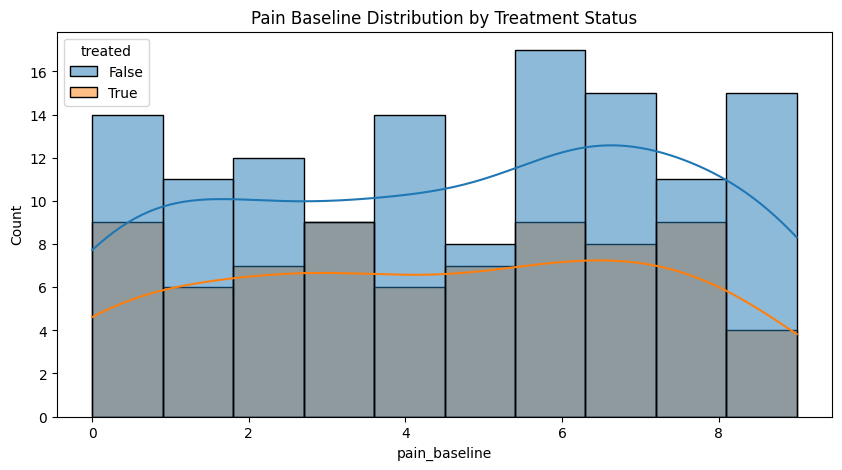

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import mahalanobis
from scipy.linalg import inv

def generate_data(n_patients=200, seed=42):
    np.random.seed(seed)

    patients = pd.DataFrame({
        'patient_id': np.arange(n_patients),
        'pain_baseline': np.random.randint(0, 10, n_patients),
        'urgency_baseline': np.random.randint(0, 10, n_patients),
        'frequency_baseline': np.random.randint(0, 10, n_patients),
        'treatment_time': np.random.choice([np.nan, 3, 6, 9], n_patients, p=[0.6, 0.15, 0.15, 0.1])
    })

    patients['treated'] = ~patients['treatment_time'].isna()
    return patients

data = generate_data()
print("Generated Patient Data:")
display(data.head())

plt.figure(figsize=(10, 5))
sns.histplot(data, x="pain_baseline", hue="treated", kde=True, bins=10)
plt.title("Pain Baseline Distribution by Treatment Status")
plt.show()


Construct Risk Sets
## Identify untreated patients for each treated patient

In [28]:
import numpy as np
import pandas as pd
import networkx as nx
from scipy.stats import rankdata
from scipy.optimize import linear_sum_assignment

def construct_risk_sets(data):
    treated = data.dropna(subset=['treatment_time'])
    untreated = data[data['treatment_time'].isna()]

    risk_sets = []
    for _, treated_row in treated.iterrows():
        subset = untreated[untreated.index < treated_row.name]  # Only prior patients
        risk_sets.append((treated_row['patient_id'], subset['patient_id'].tolist()))

    return risk_sets

risk_sets = construct_risk_sets(data)

# Display risk sets
print("Sample Risk Sets:")
display(risk_sets[:5])


Sample Risk Sets:


[(0, []), (2, [1]), (5, [1, 3, 4]), (6, [1, 3, 4]), (8, [1, 3, 4, 7])]

Compute Mahalanobis Distance and Compute covariance matrix **bold text**

In [29]:
def compute_mahalanobis(p1, p2, cov_inv):
    diff = p1 - p2
    return np.sqrt(diff.T @ cov_inv @ diff)

In [30]:
cov_matrix = data[['pain_baseline', 'urgency_baseline', 'frequency_baseline']].cov()
cov_inv = inv(cov_matrix)

#Solve Optimal Matching via Integer Programming

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import mahalanobis
from scipy.linalg import inv
from pulp import LpProblem, LpMinimize, LpVariable, lpSum

def match_patients(data, risk_sets, cov_inv):
    problem = LpProblem("Balanced_Risk_Set_Matching", LpMinimize)

    match_vars = {}
    distances = {}

    for treated_id, control_ids in risk_sets:
        for control_id in control_ids:
            p1 = data.loc[data['patient_id'] == treated_id, ['pain_baseline', 'urgency_baseline', 'frequency_baseline']].values.flatten()
            p2 = data.loc[data['patient_id'] == control_id, ['pain_baseline', 'urgency_baseline', 'frequency_baseline']].values.flatten()

            dist = compute_mahalanobis(p1, p2, cov_inv)
            var = LpVariable(f"match_{treated_id}_{control_id}", cat='Binary')

            match_vars[(treated_id, control_id)] = var
            distances[var] = dist

    # Objective: Minimize total Mahalanobis distance
    problem += lpSum(distances[var] * var for var in match_vars.values())

    # Constraints: Each treated patient is matched once
    for treated_id, _ in risk_sets:
        problem += lpSum(match_vars[(treated_id, control_id)] for control_id in data['patient_id'] if (treated_id, control_id) in match_vars) == 1

    # Solve the problem
    problem.solve()

    matches = [(treated_id, control_id) for (treated_id, control_id), var in match_vars.items() if var.varValue == 1]
    return matches

matches = match_patients(data, risk_sets, cov_inv)

#Evaluate Balance

In [32]:
def check_balance(data, matches):
    treated_values = data.loc[data['patient_id'].isin([t for t, _ in matches]), ['pain_baseline', 'urgency_baseline', 'frequency_baseline']]
    control_values = data.loc[data['patient_id'].isin([c for _, c in matches]), ['pain_baseline', 'urgency_baseline', 'frequency_baseline']]
    return treated_values.describe(), control_values.describe()

treated_stats, control_stats = check_balance(data, matches)

# Display balance check results
print("Treated Group Statistics:")
display(treated_stats)
print("Control Group Statistics:")
display(control_stats)

Treated Group Statistics:


,pain_baseline,urgency_baseline,frequency_baseline
count,73.000000,73.000000,73.000000
mean,4.356164,3.684932,4.410959
std,2.840040,3.086155,3.183445
min,0.000000,0.000000,0.000000
25%,2.000000,1.000000,2.000000
50%,4.000000,3.000000,4.000000
75%,7.000000,7.000000,8.000000
max,9.000000,9.000000,9.000000


Control Group Statistics:


,pain_baseline,urgency_baseline,frequency_baseline
count,39.000000,39.000000,39.000000
mean,4.461538,3.487179,4.794872
std,2.732323,2.936806,3.019058
min,0.000000,0.000000,0.000000
25%,2.000000,1.000000,3.000000
50%,4.000000,3.000000,4.000000
75%,6.000000,5.000000,8.000000
max,9.000000,9.000000,9.000000


#Sensitivity Analysis

Sensitivity Analysis: Balance Check after Perturbations


,pain_baseline,urgency_baseline,frequency_baseline
count,73.000000,73.000000,73.000000
mean,4.385850,3.708601,4.390423
std,2.830876,3.143605,3.210353
min,-0.210323,-0.660117,-0.492863
25%,2.048539,0.640778,1.466190
50%,4.576603,3.012255,4.185573
75%,6.749121,6.273549,7.038684
max,9.774967,10.094901,9.775576


,pain_baseline,urgency_baseline,frequency_baseline
count,39.000000,39.000000,39.000000
mean,4.380662,3.534748,4.627924
std,2.883977,3.023916,3.075285
min,-0.259135,-0.419861,-1.033721
25%,2.332087,0.846123,2.262034
50%,4.236619,3.379366,4.589649
75%,6.348276,5.428983,7.782454
max,9.487773,9.487560,9.377696


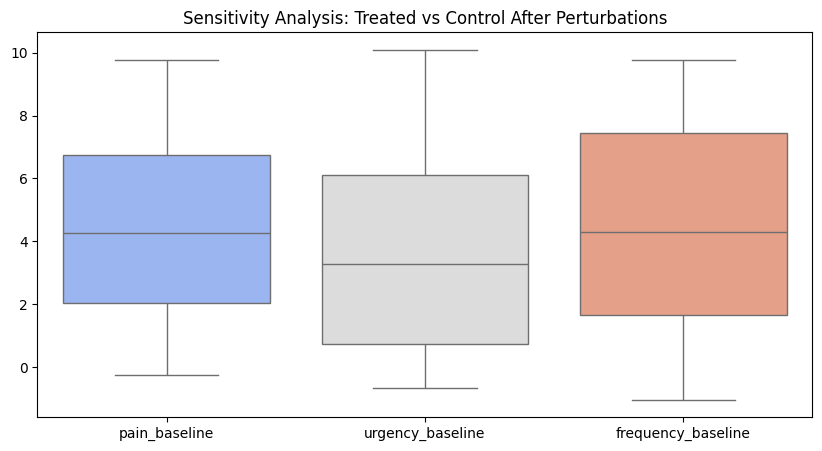

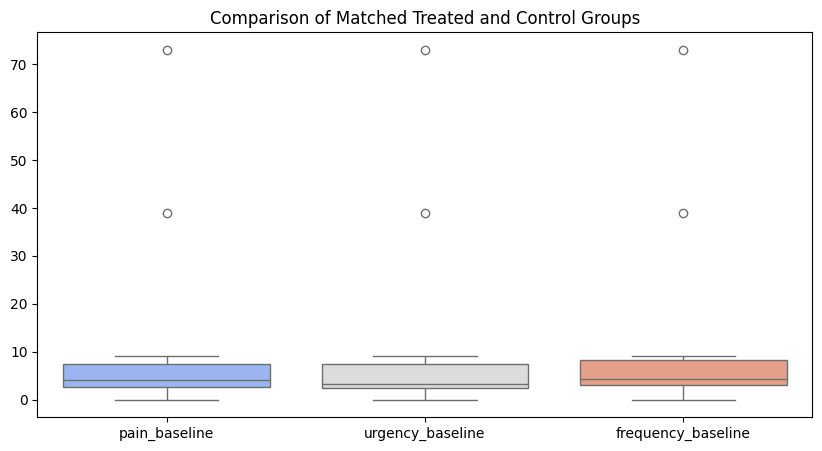

In [35]:
def sensitivity_analysis(data, matches):
    perturbed_data = data.copy()

    # Introduce small noise to covariates
    np.random.seed(42)
    for col in ['pain_baseline', 'urgency_baseline', 'frequency_baseline']:
        perturbed_data[col] += np.random.normal(0, 0.5, size=len(perturbed_data))

    # Recompute balance statistics
    treated_values = perturbed_data.loc[perturbed_data['patient_id'].isin([t for t, _ in matches]), ['pain_baseline', 'urgency_baseline', 'frequency_baseline']]
    control_values = perturbed_data.loc[perturbed_data['patient_id'].isin([c for _, c in matches]), ['pain_baseline', 'urgency_baseline', 'frequency_baseline']]

    print("Sensitivity Analysis: Balance Check after Perturbations")
    display(treated_values.describe())
    display(control_values.describe())

    # Visualization
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=pd.concat([treated_values, control_values]), palette="coolwarm")
    plt.title("Sensitivity Analysis: Treated vs Control After Perturbations")
    plt.show()

sensitivity_analysis(data, matches)


# Step 7: Visualize Matching Results
plt.figure(figsize=(10, 5))
sns.boxplot(data=pd.concat([treated_stats, control_stats]), palette="coolwarm")
plt.title("Comparison of Matched Treated and Control Groups")
plt.show()